In [1]:
import os
from pathlib import Path

from itertools import chain

import datetime

import math
import numpy as np
import pandas as pd

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [2]:
# config settings

# date of forecast generation
forecast_date = datetime.date.today()

# most recent Saturday: weekly forecasts look forward from this date
last_sat = forecast_date - datetime.timedelta((forecast_date.weekday() + 2) % 7)
last_sat

# maximum forecast horizon
max_horizon = 28

# number of bags
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35,
            0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
            0.85, 0.90, 0.95, 0.975, 0.99]
q_labels = ['0.010', '0.025', '0.050', '0.100', '0.150', '0.200', '0.250', '0.300', '0.350',
            '0.400', '0.450', '0.500', '0.550', '0.600', '0.650', '0.700', '0.750', '0.800',
            '0.850', '0.900', '0.950', '0.975', '0.990']

In [3]:
def load_data(pathogen):
    path = max(Path('data').glob(f'{pathogen}_data_cached_*.csv'))
    df = pd.read_csv(path)
    
    # drop unreliable data:
    # prior to 2020-12-01 for covid, prior to 2022-03-01 for flu
    # locations 60 and 78 for flu
    if pathogen == 'covid':
        start_date = '2020-12-01'
    elif pathogen == 'flu':
        start_date = '2022-03-01'
        df = df.loc[(df['location'] != '60') & (df['location'] != '66') & (df['location'] != '69') & (df['location'] != '78')]
    
    df = df.loc[df['date'] >= start_date]
    df['date'] = pd.to_datetime(df['date'])
    
    # log population -- a feature, but used in plots immediately below
    df['log_pop'] = np.log(df['population'])
    
    # process response variable:
    # - replace low values with 0.1, selected by looking at plots
    # - fourth root transform to stabilize variability
    # - divide by location-specific 95th percentile
    # - center relative to location-specific mean
    #   (note non-standard order of center/scale)
    df['hosp_rate_4rt'] = df['hosp_rate']
    df.loc[df['hosp_rate_4rt'] < 0.1, 'hosp_rate_4rt'] = 0.1
    df['hosp_rate_4rt'] = df['hosp_rate_4rt'] ** 0.25
    df['hosp_rate_4rt_scale_factor'] = df \
        .groupby('location')['hosp_rate_4rt'] \
        .transform(lambda x: x.quantile(0.95))
    # manual adjustment to scale factor for pathogen == 'influenza'
    # we have limited historical data, from an unusually small season
    # inflate scaling factor by 10, which is the ratio of peak weekly
    # rate from flusurv last season vs the previous largest flusurv season
    if pathogen == 'flu':
        df['hosp_rate_4rt_scale_factor'] = df['hosp_rate_4rt_scale_factor'] * 10.0
    
    df['hosp_rate_4rt_cs'] = df['hosp_rate_4rt'] / (df['hosp_rate_4rt_scale_factor'] + 0.01)
    df['hosp_rate_4rt_center_factor'] = df \
        .groupby('location')['hosp_rate_4rt_cs'] \
        .transform(lambda x: x.mean())
    df['hosp_rate_4rt_cs'] = df['hosp_rate_4rt_cs'] - df['hosp_rate_4rt_center_factor']
    
    # indicator of which pathogen
    df['pathogen_covid'] = int(pathogen == 'covid')
    
    return(df) 

      location       date  hosps  location_name  population     pop100k  \
61          01 2020-12-01    285        Alabama     4903185    49.03185   
62          01 2020-12-02    294        Alabama     4903185    49.03185   
63          01 2020-12-03    279        Alabama     4903185    49.03185   
64          01 2020-12-04    294        Alabama     4903185    49.03185   
65          01 2020-12-05    272        Alabama     4903185    49.03185   
...        ...        ...    ...            ...         ...         ...   
55989       US 2023-07-17   1229  United States   332875137  3328.75137   
55990       US 2023-07-18   1220  United States   332875137  3328.75137   
55991       US 2023-07-19   1154  United States   332875137  3328.75137   
55992       US 2023-07-20   1277  United States   332875137  3328.75137   
55993       US 2023-07-21   1274  United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4rt  hosp_rate_4rt_scale_factor  \
61      5.812548  15.4053

<AxesSubplot:xlabel='date', ylabel='hosp_rate_4rt_cs'>

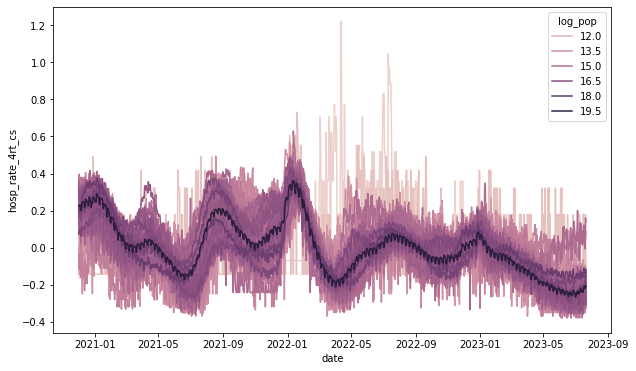

In [4]:
covid_df = load_data(pathogen='covid')
print(covid_df)

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.lineplot(data=covid_df, x='date', y='hosp_rate_4rt_cs', hue='log_pop', ax=ax)

In [5]:
# temp = covid_df.loc[(covid_df.location == "US") & (covid_df.date >= "2022-01-01") & (covid_df.date <= "2022-12-25")]
# temp2 = covid_df.loc[(covid_df.location == "US") & (covid_df.date >= "2022-01-01")]
# plt.plot(temp2['date'], temp2['hosp_rate_4rt_cs'])
# plt.plot(temp['date'], temp['hosp_rate_4rt_cs'])

In [6]:
# covid_df = covid_df.loc[(covid_df.date <= "2022-12-25")]

      location       date  hosps  location_name  population     pop100k  \
516         01 2022-03-01    7.0        Alabama     4903185    49.03185   
517         01 2022-03-02    8.0        Alabama     4903185    49.03185   
518         01 2022-03-03    2.0        Alabama     4903185    49.03185   
519         01 2022-03-04    6.0        Alabama     4903185    49.03185   
520         01 2022-03-05    6.0        Alabama     4903185    49.03185   
...        ...        ...    ...            ...         ...         ...   
55989       US 2023-07-17   91.0  United States   332875137  3328.75137   
55990       US 2023-07-18   82.0  United States   332875137  3328.75137   
55991       US 2023-07-19   96.0  United States   332875137  3328.75137   
55992       US 2023-07-20   75.0  United States   332875137  3328.75137   
55993       US 2023-07-21   78.0  United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4rt  hosp_rate_4rt_scale_factor  \
516     0.142764  15.4053

<AxesSubplot:xlabel='date', ylabel='hosp_rate_4rt_cs'>

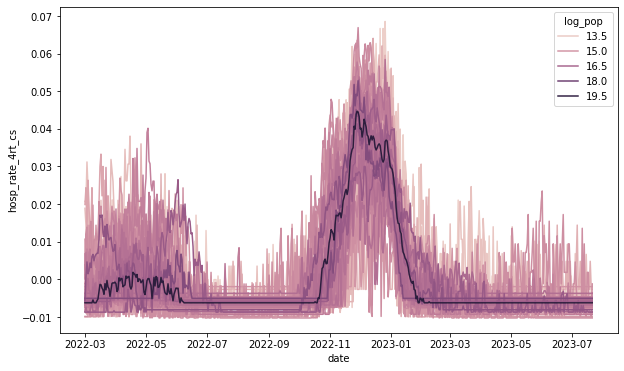

In [7]:
flu_df = load_data(pathogen='flu')
flu_df = flu_df.loc[flu_df['date'].dt.date <= last_sat]
print(flu_df)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 6)
sns.lineplot(data=flu_df, x='date', y='hosp_rate_4rt_cs', hue='log_pop', ax=ax)

### Note

We should not train on flu data between about June 1 and Oct 1, 2022. We'll drop those dates later, after feature calculations.

In [8]:
#df = pd.concat([covid_df, flu_df], axis=0)
df = covid_df
df

location       date  hosps  location_name  population     pop100k  \
61          01 2020-12-01  285.0        Alabama     4903185    49.03185   
62          01 2020-12-02  294.0        Alabama     4903185    49.03185   
63          01 2020-12-03  279.0        Alabama     4903185    49.03185   
64          01 2020-12-04  294.0        Alabama     4903185    49.03185   
65          01 2020-12-05  272.0        Alabama     4903185    49.03185   
...        ...        ...    ...            ...         ...         ...   
55989       US 2023-07-17   91.0  United States   332875137  3328.75137   
55990       US 2023-07-18   82.0  United States   332875137  3328.75137   
55991       US 2023-07-19   96.0  United States   332875137  3328.75137   
55992       US 2023-07-20   75.0  United States   332875137  3328.75137   
55993       US 2023-07-21   78.0  United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4rt  hosp_rate_4rt_scale_factor  \
61      5.812548  15.405396       1.552715                    1.671784   
62      5.996103  15.405396       1.564830                    1.671784   
63      5.690179  15.405396       1.544477                    1.671784   
64      5.996103  15.405396       1.564830                    1.671784   
65      5.547415  15.405396       1.534697                    1.671784   
...          ...        ...            ...                         ...   
55989   0.027338  19.623278       0.562341                    9.680872   
55990   0.024634  19.623278       0.562341                    9.680872   
55991   0.028840  19.623278       0.562341                    9.680872   
55992   0.022531  19.623278       0.562341                    9.680872   
55993   0.023432  19.623278       0.562341                    9.680872   

       hosp_rate_4rt_cs  hosp_rate_4rt_center_factor  pathogen_covid  
61             0.270206                     0.653048               1  
62             0.277410                     0.653048               1  
63             0.265308                     0.653048               1  
64             0.277410                     0.653048               1  
65             0.259493                     0.653048               1  
...                 ...                          ...             ...  
55989         -0.006240                     0.064268               0  
55990         -0.006240                     0.064268               0  
55991         -0.006240                     0.064268               0  
55992         -0.006240                     0.064268               0  
55993         -0.006240                     0.064268               0  

[79624 rows x 13 columns]

# Calculate features

### Misc. features based on date and location variables

In [9]:
# we previously calculated log population and
# an indicator of whether the pathogen is covid
# feat_names = ['log_pop', 'pathogen_covid']
feat_names = ['log_pop']

# one-hot encodings of day of week and location
df['dow'] = pd.to_datetime(df.date).dt.dayofweek

for c in ['location', 'dow']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

feat_names

['log_pop',
 'location_01',
 'location_02',
 'location_04',
 'location_05',
 'location_06',
 'location_08',
 'location_09',
 'location_10',
 'location_11',
 'location_12',
 'location_13',
 'location_15',
 'location_16',
 'location_17',
 'location_18',
 'location_19',
 'location_20',
 'location_21',
 'location_22',
 'location_23',
 'location_24',
 'location_25',
 'location_26',
 'location_27',
 'location_28',
 'location_29',
 'location_30',
 'location_31',
 'location_32',
 'location_33',
 'location_34',
 'location_35',
 'location_36',
 'location_37',
 'location_38',
 'location_39',
 'location_40',
 'location_41',
 'location_42',
 'location_44',
 'location_45',
 'location_46',
 'location_47',
 'location_48',
 'location_49',
 'location_50',
 'location_51',
 'location_53',
 'location_54',
 'location_55',
 'location_56',
 'location_60',
 'location_72',
 'location_78',
 'location_US',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6']

### Features summarizing time series within each location

In [10]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location', 'pathogen_covid'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [28, 42],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [14],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'group_columns': ['location'],
                'window_size': [7, 14]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location', 'pathogen_covid'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': new_feat_names,
                'lags': [7, 14]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df['empirical_deriv'] = (df['hosp_rate_4rt_cs_rollmean_w7'] - df['hosp_rate_4rt_cs_rollmean_w7_lag7']) / 7
feat_names =feat_names + ['empirical_deriv']

print(df)
print(feat_names)

      location       date   hosps  location_name  population     pop100k  \
0           01 2020-12-01   285.0        Alabama     4903185    49.03185   
1           01 2020-12-02   294.0        Alabama     4903185    49.03185   
2           01 2020-12-03   279.0        Alabama     4903185    49.03185   
3           01 2020-12-04   294.0        Alabama     4903185    49.03185   
4           01 2020-12-05   272.0        Alabama     4903185    49.03185   
...        ...        ...     ...            ...         ...         ...   
79619       US 2023-07-19  1154.0  United States   332875137  3328.75137   
79620       US 2023-07-20    75.0  United States   332875137  3328.75137   
79621       US 2023-07-20  1277.0  United States   332875137  3328.75137   
79622       US 2023-07-21    78.0  United States   332875137  3328.75137   
79623       US 2023-07-21  1274.0  United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4rt  hosp_rate_4rt_scale_factor  ...  \
0       

In [11]:
# drop features that involve absolute level
# feat_names = ['log_pop', 'pathogen_covid', 'location_01', 'location_02', 'location_04',
feat_names = ['log_pop', 'location_01', 'location_02', 'location_04',
    'location_05', 'location_06', 'location_08', 'location_09', 'location_10', 'location_11',
    'location_12', 'location_13', 'location_15', 'location_16', 'location_17', 'location_18',
    'location_19', 'location_20', 'location_21', 'location_22', 'location_23', 'location_24',
    'location_25', 'location_26', 'location_27', 'location_28', 'location_29', 'location_30',
    'location_31', 'location_32', 'location_33', 'location_34', 'location_35', 'location_36',
    'location_37', 'location_38', 'location_39', 'location_40', 'location_41', 'location_42',
    'location_44', 'location_45', 'location_46', 'location_47', 'location_48', 'location_49',
    'location_50', 'location_51', 'location_53', 'location_54', 'location_55', 'location_56',
    'location_60', 'location_72', 'location_78', 'location_US', 'dow_0', 'dow_1', 'dow_2',
    'dow_3', 'dow_4', 'dow_5', 'dow_6', 'hosp_rate_4rt_cs_taylor_d1_w28t_sNone',
    'hosp_rate_4rt_cs_taylor_d2_w28t_sNone', 'hosp_rate_4rt_cs_taylor_d1_w42t_sNone',
    'hosp_rate_4rt_cs_taylor_d2_w42t_sNone', 'hosp_rate_4rt_cs_taylor_d1_w14t_sNone',
    'hosp_rate_4rt_cs_taylor_d1_w28t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w28t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d2_w28t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d2_w28t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d1_w42t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w42t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d2_w42t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d2_w42t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag14',
    'empirical_deriv']

In [12]:
# import importlib
# featurize = importlib.reload(featurize)

# figure out horizons
# last date with observed data
last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
due_date = forecast_date
extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location', 'pathogen_covid'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'horizons': [(i+1) for i in range(effective_horizon_rel_obs)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['hosp_rate_4rt_cs_target'] - df_with_pred_targets['hosp_rate_4rt_cs_taylor_d0_w42t_sNone']

print(new_feat_names)
print(df_with_pred_targets)

last_obs_date: 2023-07-21 00:00:00
['horizon']
      location       date   hosps  location_name  population     pop100k  \
0           01 2020-12-01   285.0        Alabama     4903185    49.03185   
1           01 2020-12-02   294.0        Alabama     4903185    49.03185   
2           01 2020-12-03   279.0        Alabama     4903185    49.03185   
3           01 2020-12-04   294.0        Alabama     4903185    49.03185   
4           01 2020-12-05   272.0        Alabama     4903185    49.03185   
...        ...        ...     ...            ...         ...         ...   
79619       US 2023-07-19  1154.0  United States   332875137  3328.75137   
79620       US 2023-07-20    75.0  United States   332875137  3328.75137   
79621       US 2023-07-20  1277.0  United States   332875137  3328.75137   
79622       US 2023-07-21    78.0  United States   332875137  3328.75137   
79623       US 2023-07-21  1274.0  United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4

In [13]:
list(df_with_pred_targets.columns)

['location',
 'date',
 'hosps',
 'location_name',
 'population',
 'pop100k',
 'hosp_rate',
 'log_pop',
 'hosp_rate_4rt',
 'hosp_rate_4rt_scale_factor',
 'hosp_rate_4rt_cs',
 'hosp_rate_4rt_center_factor',
 'pathogen_covid',
 'dow',
 'location_01',
 'location_02',
 'location_04',
 'location_05',
 'location_06',
 'location_08',
 'location_09',
 'location_10',
 'location_11',
 'location_12',
 'location_13',
 'location_15',
 'location_16',
 'location_17',
 'location_18',
 'location_19',
 'location_20',
 'location_21',
 'location_22',
 'location_23',
 'location_24',
 'location_25',
 'location_26',
 'location_27',
 'location_28',
 'location_29',
 'location_30',
 'location_31',
 'location_32',
 'location_33',
 'location_34',
 'location_35',
 'location_36',
 'location_37',
 'location_38',
 'location_39',
 'location_40',
 'location_41',
 'location_42',
 'location_44',
 'location_45',
 'location_46',
 'location_47',
 'location_48',
 'location_49',
 'location_50',
 'location_51',
 'location_53',


In [14]:
df_with_pred_targets['date'].max()

Timestamp('2023-07-21 00:00:00')

In [15]:
df_with_pred_targets['horizon']

0         1
1         1
2         1
3         1
4         1
         ..
79619    38
79620    38
79621    38
79622    38
79623    38
Name: horizon, Length: 3025712, dtype: int64

In [16]:
# drop rows with missing feature values
# these show up for early dates and American Samoa
drop_rows = (np.sum(np.isnan(df_with_pred_targets.loc[:, feat_names]), axis=1) > 0).values
print(df_with_pred_targets.loc[drop_rows].date.unique())
print(df_with_pred_targets.loc[drop_rows & (df_with_pred_targets.date >= '2021-08-23')].location_name.unique())

df_with_pred_targets = df_with_pred_targets.loc[~drop_rows]

['2020-12-01T00:00:00.000000000' '2020-12-02T00:00:00.000000000'
 '2020-12-03T00:00:00.000000000' '2020-12-04T00:00:00.000000000'
 '2020-12-05T00:00:00.000000000' '2020-12-06T00:00:00.000000000'
 '2020-12-07T00:00:00.000000000' '2020-12-08T00:00:00.000000000'
 '2020-12-09T00:00:00.000000000' '2020-12-10T00:00:00.000000000'
 '2020-12-11T00:00:00.000000000' '2020-12-12T00:00:00.000000000'
 '2020-12-13T00:00:00.000000000' '2020-12-14T00:00:00.000000000'
 '2020-12-15T00:00:00.000000000' '2020-12-16T00:00:00.000000000'
 '2020-12-17T00:00:00.000000000' '2020-12-18T00:00:00.000000000'
 '2020-12-19T00:00:00.000000000' '2020-12-20T00:00:00.000000000'
 '2020-12-21T00:00:00.000000000' '2020-12-22T00:00:00.000000000'
 '2020-12-23T00:00:00.000000000' '2020-12-24T00:00:00.000000000'
 '2020-12-25T00:00:00.000000000' '2020-12-26T00:00:00.000000000'
 '2020-12-27T00:00:00.000000000' '2020-12-28T00:00:00.000000000'
 '2020-12-29T00:00:00.000000000' '2020-12-30T00:00:00.000000000'
 '2020-12-31T00:00:00.000

In [17]:
# Drop rows based on data for influenza between June 1 and Oct 1, 2022
# off-season data was unreliable
drop_rows = (df_with_pred_targets['date'] >= '2022-06-01') & \
    (df_with_pred_targets['date'] < '2022-10-01') & \
    (df_with_pred_targets['pathogen_covid'] == 0)

print(df_with_pred_targets.loc[drop_rows].date.unique())
print(df_with_pred_targets.loc[drop_rows].pathogen_covid.unique())

df_with_pred_targets = df_with_pred_targets.loc[~drop_rows]

['2022-06-01T00:00:00.000000000' '2022-06-02T00:00:00.000000000'
 '2022-06-03T00:00:00.000000000' '2022-06-04T00:00:00.000000000'
 '2022-06-05T00:00:00.000000000' '2022-06-06T00:00:00.000000000'
 '2022-06-07T00:00:00.000000000' '2022-06-08T00:00:00.000000000'
 '2022-06-09T00:00:00.000000000' '2022-06-10T00:00:00.000000000'
 '2022-06-11T00:00:00.000000000' '2022-06-12T00:00:00.000000000'
 '2022-06-13T00:00:00.000000000' '2022-06-14T00:00:00.000000000'
 '2022-06-15T00:00:00.000000000' '2022-06-16T00:00:00.000000000'
 '2022-06-17T00:00:00.000000000' '2022-06-18T00:00:00.000000000'
 '2022-06-19T00:00:00.000000000' '2022-06-20T00:00:00.000000000'
 '2022-06-21T00:00:00.000000000' '2022-06-22T00:00:00.000000000'
 '2022-06-23T00:00:00.000000000' '2022-06-24T00:00:00.000000000'
 '2022-06-25T00:00:00.000000000' '2022-06-26T00:00:00.000000000'
 '2022-06-27T00:00:00.000000000' '2022-06-28T00:00:00.000000000'
 '2022-06-29T00:00:00.000000000' '2022-06-30T00:00:00.000000000'
 '2022-07-01T00:00:00.000

In [18]:
# "test set" df used to generate look-ahead predictions
df_with_pred_targets_flu = df_with_pred_targets.loc[df_with_pred_targets.pathogen_covid == 0]
df_with_pred_targets_covid = df_with_pred_targets.loc[df_with_pred_targets.pathogen_covid == 1]
df_test = pd.concat([
    df_with_pred_targets_flu \
        .loc[df_with_pred_targets_flu.date == df_with_pred_targets_flu.date.max()] \
        .copy(),
    df_with_pred_targets_covid \
        .loc[df_with_pred_targets_covid.date == df_with_pred_targets_covid.date.max()] \
        .copy()
    ], axis = 0)
x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [19]:
df_test

location       date   hosps   location_name  population     pop100k  \
1469        01 2023-07-21     6.0         Alabama     4903185    49.03185   
2940        02 2023-07-21     0.0          Alaska      731545     7.31545   
4411        04 2023-07-21     0.0         Arizona     7278717    72.78717   
5882        05 2023-07-21     1.0        Arkansas     3017804    30.17804   
7353        06 2023-07-21     2.0      California    39512223   395.12223   
...        ...        ...     ...             ...         ...         ...   
75020       56 2023-07-21     1.0         Wyoming      578759     5.78759   
75718       60 2023-07-21     0.0  American Samoa       55641     0.55641   
77189       72 2023-07-21    35.0     Puerto Rico     3754939    37.54939   
78152       78 2023-07-21     0.0  Virgin Islands      107268     1.07268   
79623       US 2023-07-21  1274.0   United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4rt  hosp_rate_4rt_scale_factor  ...  \
1469    0.122369  15.405396       0.591450                    9.443796  ...   
2940    0.000000  13.502914       0.562341                    9.890409  ...   
4411    0.000000  15.800465       0.562341                   10.353840  ...   
5882    0.033137  14.920040       0.562341                   10.568465  ...   
7353    0.005062  17.492121       0.562341                    8.846490  ...   
...          ...        ...            ...                         ...  ...   
75020   0.172783  13.268641       0.644727                    1.545269  ...   
75718   0.000000  10.926676       0.562341                    1.376920  ...   
77189   0.932106  15.138583       0.982576                    1.084276  ...   
78152   0.000000  11.583086       0.562341                    1.293191  ...   
79623   0.382726  19.623278       0.786542                    1.477350  ...   

       hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag7  \
1469                                -2.163713e-19   
2940                                 1.116176e-04   
4411                                -1.995341e-05   
5882                                -5.635523e-19   
7353                                -9.841326e-20   
...                                           ...   
75020                               -3.280399e-03   
75718                               -2.453859e-18   
77189                                8.122247e-04   
78152                                2.835113e-03   
79623                                2.201356e-03   

       hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag14  \
1469                                 -2.163713e-19   
2940                                 -3.617674e-04   
4411                                  1.995341e-05   
5882                                 -5.635523e-19   
7353                                 -9.841326e-20   
...                                            ...   
75020                                 5.700614e-03   
75718                                -2.453859e-18   
77189                                 7.185816e-03   
78152                                -6.379005e-03   
79623                                 6.221833e-04   

       hosp_rate_4rt_cs_rollmean_w7_lag7  hosp_rate_4rt_cs_rollmean_w7_lag14  \
1469                           -0.236058                           -0.212042   
2940                           -0.135009                           -0.123286   
4411                           -0.231482                           -0.225515   
5882                           -0.309890                           -0.248617   
7353                           -0.152418                           -0.149620   
...                                  ...                                 ...   
75020                          -0.178527                           -0.189732   
75718                          -0.069742                           -0.069742   
77189                           0.068642                            0.044203   
78152                          -0.051148      

In [20]:
# Set up partitions of data into time blocks for bagging
# TODO? Consider also partitioning by pathogen
T = (pd.to_datetime(df_train.date.max()) - pd.to_datetime(df_train.date.min())).days
num_time_blocks = T // 28
time_block_starts = [pd.to_datetime(df_train.date.min()) + datetime.timedelta(days=28*i) \
    for i in range(num_time_blocks)]
time_block_lengths = [28]*(num_time_blocks - 1) + \
    [(pd.to_datetime(df_train.date.max()) - time_block_starts[-1] + datetime.timedelta(days=1)).days]
time_block_dates = [[(time_block_starts[j] + datetime.timedelta(days=i)) \
    for i in range(time_block_lengths[j])] for j in range(num_time_blocks)]

In [21]:
# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags))

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_block_inds = np.random.choice(num_time_blocks,
                            size = int(num_time_blocks*bag_frac_samples),
                            replace=False).astype(int)
    bag_block_inds = np.sort(bag_block_inds)
    bag_obs_dates = [time_block_dates[j] for j in bag_block_inds]
    bag_obs_dates = [str(d.date()) for d in list(chain.from_iterable(bag_obs_dates))]
    bag_obs_inds = df_train['date'].isin(bag_obs_dates)

    # oob_block_inds = [i for i in range(num_time_blocks) if i not in bag_block_inds]
    # oob_obs_dates = [time_block_dates[j] for j in oob_block_inds]
    # oob_obs_dates = [str(d.date()) for d in list(chain.from_iterable(oob_obs_dates))]
    # oob_obs_inds = df_train['date'].isin(oob_obs_dates)
    
    # fit to bag
    model = lgb.LGBMRegressor(verbosity=-1,
                                hist_pool_size=1000,
                                objective='mean_absolute_error')
                            #   objective='quantile',
                            #   alpha = q_level)
    model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
    
    # oob predictions and test set predictions
    oob_preds_by_bag[~bag_obs_inds, b] = model.predict(X=x_train.loc[~bag_obs_inds, :])
    test_preds_by_bag[:, b] = model.predict(X=x_test)


bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
b

In [22]:
df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_66954/1539517525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)


In [23]:
df_test.loc[df_test.pathogen_covid == 1]

location       date   hosps   location_name  population     pop100k  \
1470        01 2023-07-21    19.0         Alabama     4903185    49.03185   
2941        02 2023-07-21     1.0          Alaska      731545     7.31545   
4412        04 2023-07-21    24.0         Arizona     7278717    72.78717   
5883        05 2023-07-21     7.0        Arkansas     3017804    30.17804   
7354        06 2023-07-21   190.0      California    39512223   395.12223   
...        ...        ...     ...             ...         ...         ...   
75020       56 2023-07-21     1.0         Wyoming      578759     5.78759   
75718       60 2023-07-21     0.0  American Samoa       55641     0.55641   
77189       72 2023-07-21    35.0     Puerto Rico     3754939    37.54939   
78152       78 2023-07-21     0.0  Virgin Islands      107268     1.07268   
79623       US 2023-07-21  1274.0   United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4rt  hosp_rate_4rt_scale_factor  ...  \
1470    0.387503  15.405396       0.788985                    1.671784  ...   
2941    0.136697  13.502914       0.608051                    1.359643  ...   
4412    0.329728  15.800465       0.757773                    1.619336  ...   
5883    0.231957  14.920040       0.693988                    1.564720  ...   
7354    0.480864  17.492121       0.832733                    1.491201  ...   
...          ...        ...            ...                         ...  ...   
75020   0.172783  13.268641       0.644727                    1.545269  ...   
75718   0.000000  10.926676       0.562341                    1.376920  ...   
77189   0.932106  15.138583       0.982576                    1.084276  ...   
78152   0.000000  11.583086       0.562341                    1.293191  ...   
79623   0.382726  19.623278       0.786542                    1.477350  ...   

       hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag14  \
1470                                  1.562572e-03   
2941                                  2.621868e-03   
4412                                  1.542792e-03   
5883                                 -2.855502e-03   
7354                                  1.585135e-04   
...                                            ...   
75020                                 5.700614e-03   
75718                                -2.453859e-18   
77189                                 7.185816e-03   
78152                                -6.379005e-03   
79623                                 6.221833e-04   

       hosp_rate_4rt_cs_rollmean_w7_lag7  hosp_rate_4rt_cs_rollmean_w7_lag14  \
1470                           -0.224639                           -0.204924   
2941                           -0.147008                           -0.131332   
4412                           -0.220688                           -0.218040   
5883                           -0.317106                           -0.260919   
7354                           -0.151815                           -0.150739   
...                                  ...                                 ...   
75020                          -0.178527                           -0.189732   
75718                          -0.069742                           -0.069742   
77189                           0.068642                            0.044203   
78152                          -0.051148                           -0.143289   
79623                          -0.245964                           -0.249284   

       hosp_rate_4rt_cs_rollmean_w14_lag7  \
1470                            -0.230191   
2941                            -0.155687   
4412                            -0.222329   
5883                            -0.300839   
7354                            -0.152687   
...                                   ...   
75020                           -0.202848   
75718                           -0.069742   
77189                            0.059339   
78152                           -0.097219   
79623                      

In [24]:
# qs = df_train.groupby(['log_pop', 'horizon', 'pathogen_covid'])['oob_pred_resid'].quantile(np.arange(0.1, 1.0, 0.1)).reset_index()
# qs
# g = sns.FacetGrid(qs, row='horizon', col='level_3')
# g.map(sns.scatterplot, 'log_pop', 'oob_pred_resid', 'pathogen_covid')

In [25]:
# daily predictions
df_train['oob_pred_resid'] = df_train['oob_pred'] - df_train['delta_target']

for q_level, q_label in zip(q_levels, q_labels):
    # basically do a split conformal idea per location and horizon to get quantiles,
    # but ignore the finite sample size adjustment
    oob_resid_q = df_train.groupby(['location', 'horizon', 'pathogen_covid'])['oob_pred_resid'].quantile(q_level)
    df_test = df_test.merge(oob_resid_q.reset_index(), on=['location', 'horizon', 'pathogen_covid'])
    df_test[q_label] = df_test['delta_hat_stage1'] + df_test['oob_pred_resid']
    df_test.drop(columns=['oob_pred_resid'], inplace=True)

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_66954/1976052202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['oob_pred_resid'] = df_train['oob_pred'] - df_train['delta_target']


In [26]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['location', 'date', 'pop100k', 'pathogen_covid',
                'hosp_rate_4rt_cs_taylor_d0_w42t_sNone', 'horizon',
                'hosp_rate_4rt_center_factor', 'hosp_rate_4rt_scale_factor']
preds_df = df_test[cols_to_keep + q_labels]
preds_df = pd.melt(preds_df,
                   id_vars=cols_to_keep,
                   var_name='quantile',
                   value_name = 'delta_hat')

# build data frame with predictions on the original scale
preds_df['hosp_rate_4rt_cs_target_hat'] = preds_df['hosp_rate_4rt_cs_taylor_d0_w42t_sNone'] + preds_df['delta_hat']
preds_df['hosp_rate_4rt_target_hat'] = (preds_df['hosp_rate_4rt_cs_target_hat'] + preds_df['hosp_rate_4rt_center_factor']) * preds_df['hosp_rate_4rt_scale_factor']
# preds_df['hosp_rate_target_hat'] = preds_df['hosp_rate_4rt_target_hat'] ** 4
preds_df.loc[(preds_df['pathogen_covid'] == 0) & (preds_df['hosp_rate_4rt_target_hat'] < 0.0)]

location       date   pop100k  pathogen_covid  \
884         40 2023-07-21  39.56971               0   
937         40 2023-07-21  39.56971               0   
990         40 2023-07-21  39.56971               0   
1043        40 2023-07-21  39.56971               0   
1096        40 2023-07-21  39.56971               0   
...        ...        ...       ...             ...   
10091       32 2023-07-21  30.80156               0   
10099       40 2023-07-21  39.56971               0   
10152       40 2023-07-21  39.56971               0   
10197       32 2023-07-21  30.80156               0   
10205       40 2023-07-21  39.56971               0   

       hosp_rate_4rt_cs_taylor_d0_w42t_sNone  horizon  \
884                                -0.010266       17   
937                                -0.010266       18   
990                                -0.010266       19   
1043                               -0.010266       20   
1096                               -0.010266       21   
...                                      ...      ...   
10091                              -0.008853       36   
10099                              -0.010266       36   
10152                              -0.010266       37   
10197                              -0.008853       38   
10205                              -0.010266       38   

       hosp_rate_4rt_center_factor  hosp_rate_4rt_scale_factor quantile  \
884                       0.055330                   12.468939    0.010   
937                       0.055330                   12.468939    0.010   
990                       0.055330                   12.468939    0.010   
1043                      0.055330                   12.468939    0.010   
1096                      0.055330                   12.468939    0.010   
...                            ...                         ...      ...   
10091                     0.065519                    9.934297    0.050   
10099                     0.055330                   12.468939    0.050   
10152                     0.055330                   12.468939    0.050   
10197                     0.065519                    9.934297    0.050   
10205                     0.055330                   12.468939    0.050   

       delta_hat  hosp_rate_4rt_cs_target_hat  hosp_rate_4rt_target_hat  
884    -0.045748                    -0.056015                 -0.008539  
937    -0.046783                    -0.057050                 -0.021448  
990    -0.048104                    -0.058370                 -0.037914  
1043   -0.049660                    -0.059926                 -0.057315  
1096   -0.051857                    -0.062123                 -0.084706  
...          ...                          ...                       ...  
10091  -0.057978                    -0.066831                 -0.013035  
10099  -0.052827                    -0.063093                 -0.096800  
10152  -0.052756                    -0.063022                 -0.095918  
10197  -0.057200                    -0.066053                 -0.005304  
10205  -0.052608                    -0.062875                 -0.094081  

[231 rows x 12 columns]

In [27]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['location', 'date', 'pop100k', 'pathogen_covid',
                'hosp_rate_4rt_cs_taylor_d0_w42t_sNone', 'horizon',
                'hosp_rate_4rt_center_factor', 'hosp_rate_4rt_scale_factor']
preds_df = df_test[cols_to_keep + q_labels]
preds_df = pd.melt(preds_df,
                   id_vars=cols_to_keep,
                   var_name='quantile',
                   value_name = 'delta_hat')

# build data frame with predictions on the original scale
preds_df['hosp_rate_4rt_cs_target_hat'] = preds_df['hosp_rate_4rt_cs_taylor_d0_w42t_sNone'] + preds_df['delta_hat']
preds_df['hosp_rate_4rt_target_hat'] = (preds_df['hosp_rate_4rt_cs_target_hat'] + preds_df['hosp_rate_4rt_center_factor']) * preds_df['hosp_rate_4rt_scale_factor']
preds_df['hosp_rate_target_hat'] = preds_df['hosp_rate_4rt_target_hat'] ** 4
preds_df['value'] = preds_df['hosp_rate_target_hat'] * preds_df['pop100k']
preds_df['target_end_date'] = pd.to_datetime(preds_df['date']) + pd.to_timedelta(preds_df['horizon'], unit='days')
preds_df = preds_df[['location', 'target_end_date', 'pathogen_covid', 'quantile', 'value']]

# daily predictions: add target column with horizon relative to forecast date
preds_df['forecast_date'] = str(forecast_date)
preds_df['horizon'] = (preds_df['target_end_date'].dt.date - forecast_date).dt.days

daily_preds_df = preds_df.loc[(preds_df['horizon'] > 0) & (preds_df['horizon'] <= max_horizon)]
daily_preds_df['target'] = daily_preds_df['horizon'].astype('str') + ' day ahead inc hosp'
daily_preds_df['type'] = 'quantile'
daily_preds_df.drop(columns=['horizon'], inplace=True)

# add point predictions
daily_pt_preds = daily_preds_df.loc[daily_preds_df['quantile'] == '0.500'].copy()
daily_pt_preds['type'] = 'point'
daily_pt_preds['quantile'] = 'NA'
daily_preds_df = pd.concat([daily_preds_df, daily_pt_preds], axis=0)
daily_preds_df

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_66954/747334403.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_preds_df['target'] = daily_preds_df['horizon'].astype('str') + ' day ahead inc hosp'
/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_66954/747334403.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_preds_df['type'] = 'quantile'
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy 

location target_end_date  pathogen_covid quantile        value  \
530         01      2023-08-01               0    0.010     0.449542   
531         02      2023-08-01               0    0.010     0.009681   
532         04      2023-08-01               0    0.010     0.637195   
533         05      2023-08-01               0    0.010     0.131444   
534         06      2023-08-01               0    0.010     9.836679   
...        ...             ...             ...      ...          ...   
49243       56      2023-08-28               1       NA     1.257522   
49244       60      2023-08-28               1       NA     0.054054   
49245       72      2023-08-28               1       NA    22.372996   
49246       78      2023-08-28               1       NA     0.205368   
49247       US      2023-08-28               1       NA  1232.196620   

      forecast_date                 target      type  
530      2023-07-31   1 day ahead inc hosp  quantile  
531      2023-07-31   1 day ahead inc hosp  quantile  
532      2023-07-31   1 day ahead inc hosp  quantile  
533      2023-07-31   1 day ahead inc hosp  quantile  
534      2023-07-31   1 day ahead inc hosp  quantile  
...             ...                    ...       ...  
49243    2023-07-31  28 day ahead inc hosp     point  
49244    2023-07-31  28 day ahead inc hosp     point  
49245    2023-07-31  28 day ahead inc hosp     point  
49246    2023-07-31  28 day ahead inc hosp     point  
49247    2023-07-31  28 day ahead inc hosp     point  

[72576 rows x 8 columns]

In [28]:
# weekly scale for influenza
# just aggregate the quantiles
# this is wrong, but in a conservative way -- assumes exact dependence
# across daily forecast horizons, which yields wider intervals
# weekly_flu_preds_df = preds_df \
#     .loc[(preds_df['pathogen_covid'] == 0) &
#          (preds_df['target_end_date'].dt.date > last_sat) &
#          (preds_df['target_end_date'].dt.date <= (last_sat + datetime.timedelta(days=28)))] \
#     .copy() \
#     .assign(horizon = lambda x: x['horizon'] // 7 + 1) \
#     .groupby(['location', 'quantile', 'horizon', 'forecast_date']) \
#     .sum() \
#     .reset_index() \
#     .assign(
#         target_end_date = lambda x: pd.to_datetime(last_sat) + pd.to_timedelta(x['horizon'] * 7, unit='days'),
#         target = lambda x: x['horizon'].astype('str') + ' wk ahead inc flu hosp',
#         type = 'quantile'
#     ) \
#     .drop(columns=['pathogen_covid', 'horizon'])

# # add point predictions
# weekly_pt_preds = weekly_flu_preds_df.loc[weekly_flu_preds_df['quantile'] == '0.500'].copy()
# weekly_pt_preds['type'] = 'point'
# weekly_pt_preds['quantile'] = 'NA'
# weekly_flu_preds_df = pd.concat([weekly_flu_preds_df, weekly_pt_preds], axis=0)

# weekly_flu_preds_df

location quantile forecast_date        value target_end_date  \
0          01    0.010    2023-07-31     0.548727      2023-07-29   
1          01    0.010    2023-07-31     1.955021      2023-08-05   
2          01    0.010    2023-07-31     0.379235      2023-08-12   
3          01    0.010    2023-07-31     0.190001      2023-08-19   
4          01    0.010    2023-07-31     0.245698      2023-08-26   
...       ...      ...           ...          ...             ...   
6035       US       NA    2023-07-31   331.502381      2023-07-29   
6036       US       NA    2023-07-31  2320.516893      2023-08-05   
6037       US       NA    2023-07-31  2320.517331      2023-08-12   
6038       US       NA    2023-07-31  2320.517398      2023-08-19   
6039       US       NA    2023-07-31  1989.015127      2023-08-26   

                       target      type  
0     0 wk ahead inc flu hosp  quantile  
1     1 wk ahead inc flu hosp  quantile  
2     2 wk ahead inc flu hosp  quantile  
3     3 wk ahead inc flu hosp  quantile  
4     4 wk ahead inc flu hosp  quantile  
...                       ...       ...  
6035  0 wk ahead inc flu hosp     point  
6036  1 wk ahead inc flu hosp     point  
6037  2 wk ahead inc flu hosp     point  
6038  3 wk ahead inc flu hosp     point  
6039  4 wk ahead inc flu hosp     point  

[6360 rows x 7 columns]

In [29]:
for subdir in ['submissions/flu/UMass-gbq', 'submissions/covid/UMass-gbq']:
    if not Path(subdir).exists():
        Path(subdir).mkdir(parents=True)

# daily_preds_df.loc[preds_df['pathogen_covid'] == 0] \
#     .drop(columns='pathogen_covid') \
#     .to_csv(f'submissions/flu/UMass-gbq/{str(forecast_date)}-UMass-gbq-daily.csv', index=False)

# weekly_flu_preds_df.to_csv(f'submissions/flu/UMass-gbq/{str(forecast_date)}-UMass-gbq.csv', index=False)

daily_preds_df.loc[preds_df['pathogen_covid'] == 1] \
    .drop(columns='pathogen_covid') \
    .to_csv(f'submissions/covid/UMass-gbq/{str(forecast_date)}-UMass-gbq.csv', index=False)

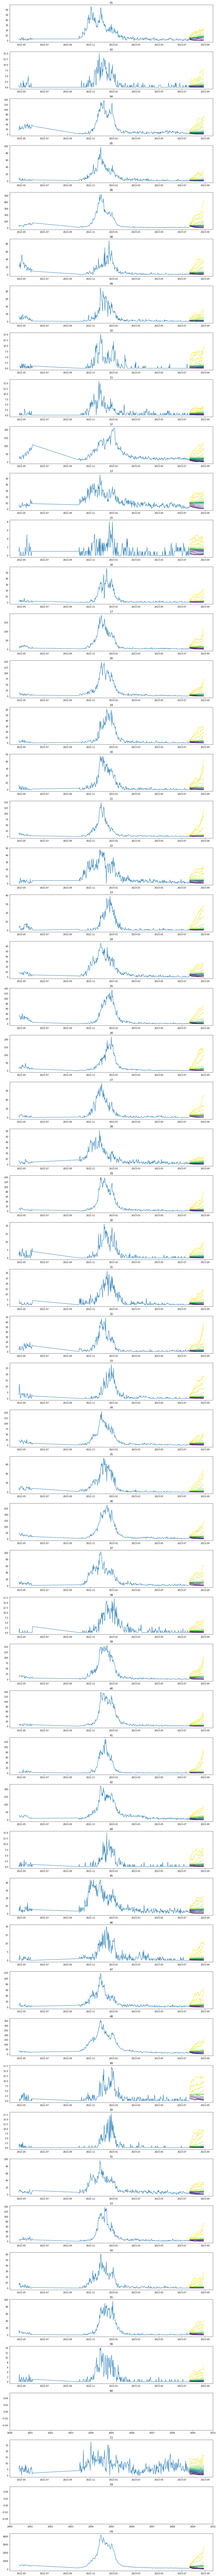

In [30]:
# cmap = cm.get_cmap('viridis')
# fig_ncol = 1
# fig_nrow = math.ceil(len(df_with_pred_targets.location.unique()) / fig_ncol)
# fig, ax = plt.subplots(fig_nrow, fig_ncol, figsize=(14, 3 * fig_nrow), squeeze=False)

# for i, loc in enumerate(df_with_pred_targets.location.unique()):
#     row_ind = ((i) // fig_ncol)
#     col_ind = (i) % fig_ncol
#     loc_data = df_with_pred_targets.loc[(df_with_pred_targets.pathogen_covid == 0) & (df_with_pred_targets.location == loc) & (df_with_pred_targets.date >= "2022-01-01")].sort_values('date')
#     ax[row_ind, col_ind].plot(pd.to_datetime(loc_data.date), loc_data.hosps)
#     for q_level, q_label in zip(q_levels, q_labels):
#         loc_q_preds = preds_df.loc[(preds_df.pathogen_covid == 0) & (preds_df.location == loc) & (preds_df['quantile'] == q_label)].sort_values('target_end_date')
#         ax[row_ind, col_ind].plot(loc_q_preds.target_end_date, loc_q_preds.value, c=cmap(q_level))
#     # ax[row_ind, col_ind].set_xlim(np.min(h_data.date), np.max(h_data.date))
#     ax[row_ind, col_ind].set(title=loc)
#     # ax[row_ind, col_ind].legend()

# plt.tight_layout()
# plt.show()

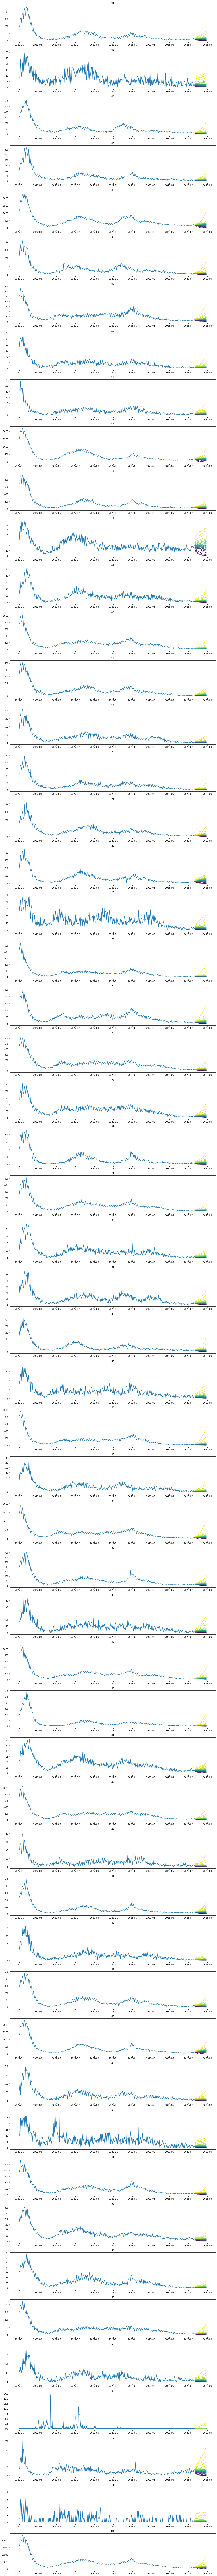

In [31]:
cmap = cm.get_cmap('viridis')
fig_ncol = 1
fig_nrow = math.ceil(len(df_with_pred_targets.location.unique()) / fig_ncol)
fig, ax = plt.subplots(fig_nrow, fig_ncol, figsize=(14, 3 * fig_nrow), squeeze=False)

for i, loc in enumerate(df_with_pred_targets.location.unique()):
    row_ind = ((i) // fig_ncol)
    col_ind = (i) % fig_ncol
    loc_data = df_with_pred_targets.loc[(df_with_pred_targets.pathogen_covid == 1) & (df_with_pred_targets.location == loc) & (df_with_pred_targets.date >= "2022-01-01")].sort_values('date')
    ax[row_ind, col_ind].plot(pd.to_datetime(loc_data.date), loc_data.hosps)
    for q_level, q_label in zip(q_levels, q_labels):
        loc_q_preds = preds_df.loc[(preds_df.pathogen_covid == 1) & (preds_df.location == loc) & (preds_df['quantile'] == q_label)].sort_values('target_end_date')
        ax[row_ind, col_ind].plot(loc_q_preds.target_end_date, loc_q_preds.value, c=cmap(q_level))
    # ax[row_ind, col_ind].set_xlim(np.min(h_data.date), np.max(h_data.date))
    ax[row_ind, col_ind].set(title=loc)
    # ax[row_ind, col_ind].legend()

plt.tight_layout()
plt.show()